### PREDICTING STOCK MARKET USING BOOSTING MODELS 

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
# Define the ticker symbol for SP500
ticker_symbol = "^GSPC"

# Set the start and end dates for the historical data
start_date = "2022-01-01"
end_date = "2024-01-01"

# Fetch historical data
df = yf.download(ticker_symbol, start=start_date, end=end_date)

# show data
print(df.shape)
print(df.head())

[*********************100%%**********************]  1 of 1 completed
(501, 6)
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-01-03  4778.140137  4796.640137  4758.169922  4796.560059  4796.560059   
2022-01-04  4804.509766  4818.620117  4774.270020  4793.540039  4793.540039   
2022-01-05  4787.990234  4797.700195  4699.439941  4700.580078  4700.580078   
2022-01-06  4693.390137  4725.009766  4671.259766  4696.049805  4696.049805   
2022-01-07  4697.660156  4707.950195  4662.740234  4677.029785  4677.029785   

                Volume  
Date                    
2022-01-03  3831020000  
2022-01-04  4683170000  
2022-01-05  4887960000  
2022-01-06  4295280000  
2022-01-07  4181510000  


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,4778.140137,4796.640137,4758.169922,4796.560059,4796.560059,3831020000
2022-01-04,4804.509766,4818.620117,4774.270020,4793.540039,4793.540039,4683170000
2022-01-05,4787.990234,4797.700195,4699.439941,4700.580078,4700.580078,4887960000
2022-01-06,4693.390137,4725.009766,4671.259766,4696.049805,4696.049805,4295280000
2022-01-07,4697.660156,4707.950195,4662.740234,4677.029785,4677.029785,4181510000


<Axes: xlabel='Date'>

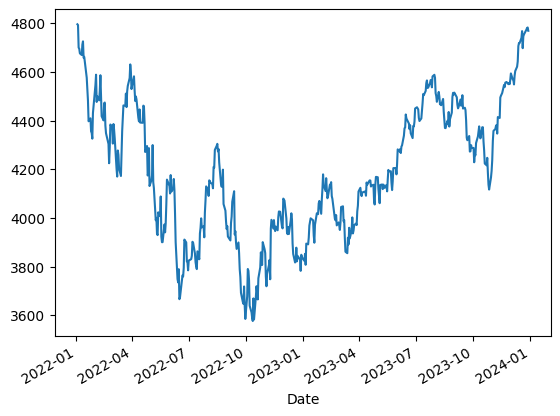

In [4]:
#Plot the data
df['Close'].plot()

### Data preprocessing

In [5]:
# # create lagged features
# df['Open_lag1'] = df['Open'].shift(1)
# df['Volume_lag1'] = df['Volume'].shift(1)


df['Open_lag1'] = df['Open']
df['Volume_lag1'] = df['Volume']

# create target variable
df['Close_target'] = df['Close'].shift(-1)

# drop rows with missing values
df.dropna(inplace=True)

#### Split data into training and testing data 

In [6]:
# split the data into train and test sets
train, test = train_test_split(df, test_size=0.015, shuffle=False)

In [7]:
# separate the input and output columns
X_train = train[['Open_lag1', 'Volume_lag1']]
y_train = train['Close_target']
X_test = test[['Open_lag1', 'Volume_lag1']]
y_test = test['Close_target']

In [8]:
print(df.shape)
print(train.shape)
print(test.shape)

(500, 9)
(492, 9)
(8, 9)


In [9]:
# Define hyperparameters grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300, 1000],
    'learning_rate': [0.0001, 0.01, 0.1, 0.2, 1],
    'max_depth': [3, 4, 5, 6, 10, 20],
}

model = xgb.XGBRegressor()

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# Predict using the tuned model
y_pred = best_model.predict(X_test)

In [10]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
# print the RMSE
print('RMSE: %.3f' % rmse)

RMSE: 42.012


### Visualizations

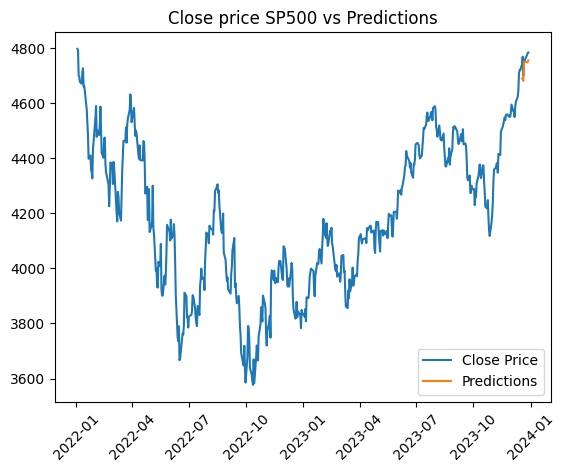

In [11]:
# plot predictions and close price
plt.plot(df["Close"], label = 'Close Price')
plt.plot(y_test.index, y_pred,label = 'Predictions')
plt.xticks(rotation=45)
plt.title('Close price SP500 vs Predictions')
plt.legend()
plt.show()

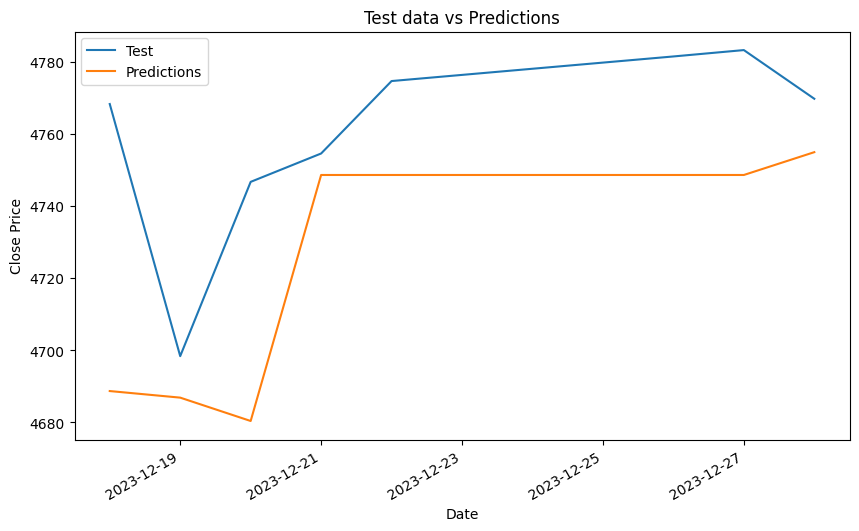

In [12]:
# create a dataframe with the test and predictions data
df1 = pd.DataFrame({'Test': y_test, 'Predictions': y_pred})

# plot the test and predictions data
df1.plot(kind='line', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Test data vs Predictions')
plt.legend()
plt.show()

In [13]:
# create an XGBRegressor model
model = xgb.XGBRegressor()

# fit the model on the train set
model.fit(X_train, y_train)

# make a prediction on the test set
y_pred = model.predict(X_test)

In [14]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
# print the RMSE
print('RMSE: %.3f' % rmse)

RMSE: 48.049


In [12]:
def create_features(df, target):
    
    df['Date'] = df.index
    df['hour'] = df['Date'].dt.hour
    
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if target:
        y = df[target]
        return X, y
    return X

In [13]:
testX_future, testY_future = create_features(df, target='Close')

In [14]:
testX_future

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth
Date,,,,,,,
2022-01-03,0,0,1,1,2022,3,3
2022-01-04,0,1,1,1,2022,4,4
2022-01-05,0,2,1,1,2022,5,5
2022-01-06,0,3,1,1,2022,6,6
2022-01-07,0,4,1,1,2022,7,7
...,...,...,...,...,...,...,...
2023-12-22,0,4,4,12,2023,356,22
2023-12-26,0,1,4,12,2023,360,26
2023-12-27,0,2,4,12,2023,361,27


In [15]:
testY_future

Date
2022-01-03    4796.560059
2022-01-04    4793.540039
2022-01-05    4700.580078
2022-01-06    4696.049805
2022-01-07    4677.029785
                 ...     
2023-12-22    4754.629883
2023-12-26    4774.750000
2023-12-27    4781.580078
2023-12-28    4783.350098
2023-12-29    4769.830078
Name: Close, Length: 501, dtype: float64

In [5]:
train = df.iloc[:int(.98 * len(df)), :]
test = df.iloc[int(.98 * len(df)):, :]

print(train.shape)
print(test.shape)

(490, 6)
(11, 6)


In [6]:
# Picking features
features = ["Open", "Volume"]
target = "Close"

#### Train Model

In [7]:
model = xgb.XGBRegressor()
model.fit(train[features], train[target])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [8]:
# Create predictions using testing data 
predictions = model.predict(test[features])
print(predictions)

[4706.8003 4714.2056 4717.7256 4719.358  4664.809  4719.6694 4727.1875
 4726.5093 4726.5093 4790.4844 4788.1426]


In [9]:
# show actual values
print(test)

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-12-14  4721.040039  4738.569824  4694.339844  4719.549805  4719.549805   
2023-12-15  4714.229980  4725.529785  4704.689941  4719.189941  4719.189941   
2023-12-18  4725.580078  4749.520020  4725.580078  4740.560059  4740.560059   
2023-12-19  4743.720215  4768.689941  4743.720215  4768.370117  4768.370117   
2023-12-20  4764.729980  4778.009766  4697.819824  4698.350098  4698.350098   
2023-12-21  4724.290039  4748.709961  4708.350098  4746.750000  4746.750000   
2023-12-22  4753.919922  4772.939941  4736.770020  4754.629883  4754.629883   
2023-12-26  4758.859863  4784.720215  4758.450195  4774.750000  4774.750000   
2023-12-27  4773.450195  4785.390137  4768.899902  4781.580078  4781.580078   
2023-12-28  4786.439941  4793.299805  4780.979980  4783.350098  4783.350098   
2023-12-29  4782.879883  4788.430176  4751.990234  4

In [10]:
# show the model accuracy
accuracy = model.score(test[features], test[target])
print(accuracy)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test[target], predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

-0.41348469849746894
Root Mean Squared Error (RMSE): 32.28938862253894


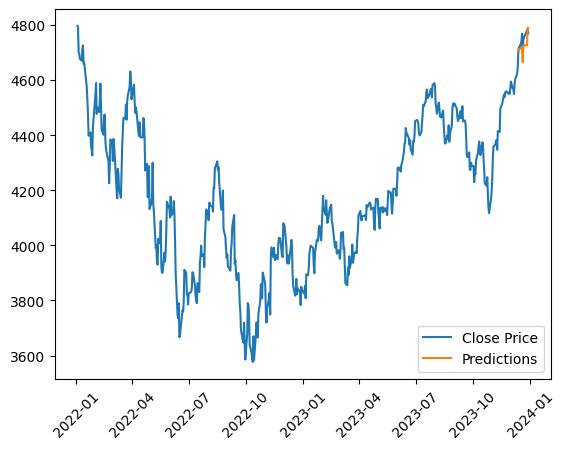

In [11]:
# plot predictions and close price
plt.plot(df["Close"], label = 'Close Price')
plt.plot(test[target].index, predictions,label = 'Predictions')
plt.xticks(rotation=45)
plt.title('Close price SP500 vs Predictions')
plt.legend()
plt.show()

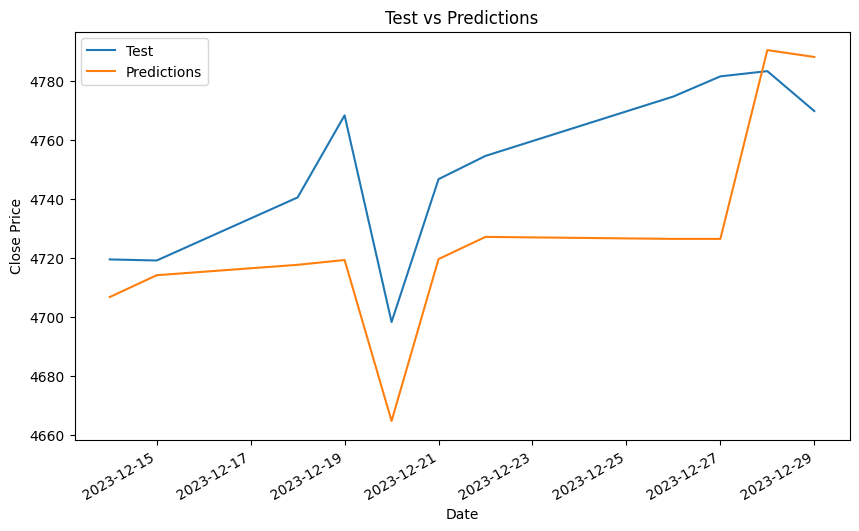

In [12]:
# create a dataframe with the test and predictions data
df1 = pd.DataFrame({'Test': test[target], 'Predictions': predictions})

# plot the test and predictions data
df1.plot(kind='line', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Test vs Predictions')
plt.legend()
plt.show()

In [25]:
# create a dataframe with the new dates and the features
new_dates = pd.date_range(start='2024-01-15', end='2024-01-21', freq='H')
new_data = pd.DataFrame(new_dates, columns=['Date'])
new_data["Close"] = np.nan
predictions_new = model.predict(new_data)
predictions_new
new_data

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Date: datetime64[ns]

Let's create fine tuning the model and compare the results

In [16]:
# Define hyperparameters grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300, 1000],
    'learning_rate': [0.0001, 0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 10, 20],
    #'subsample': [0.8, 0.9, 1.0],
    #'colsample_bytree': [0.8, 0.9, 1.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(train[features], train[target])

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(train[features], train[target])

# Predict using the tuned model
predictions = best_model.predict(test[features])

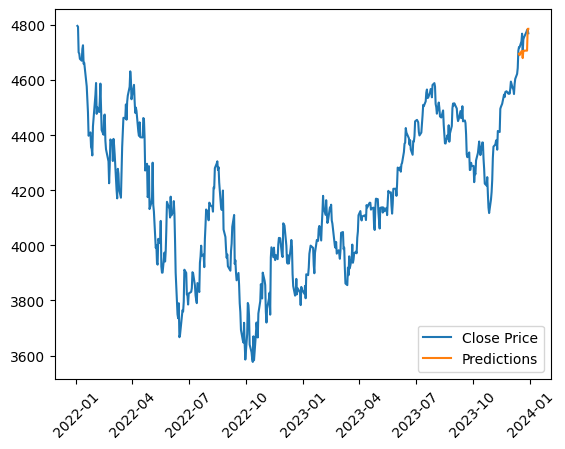

Root Mean Squared Error (RMSE): 44.26383999171728


In [17]:
# Applying best model
predictions = best_model.predict(test[features])

# Plotting  results
plt.plot(df["Close"], label = 'Close Price')
plt.plot(test[target].index, predictions,label = 'Predictions')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test[target], predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

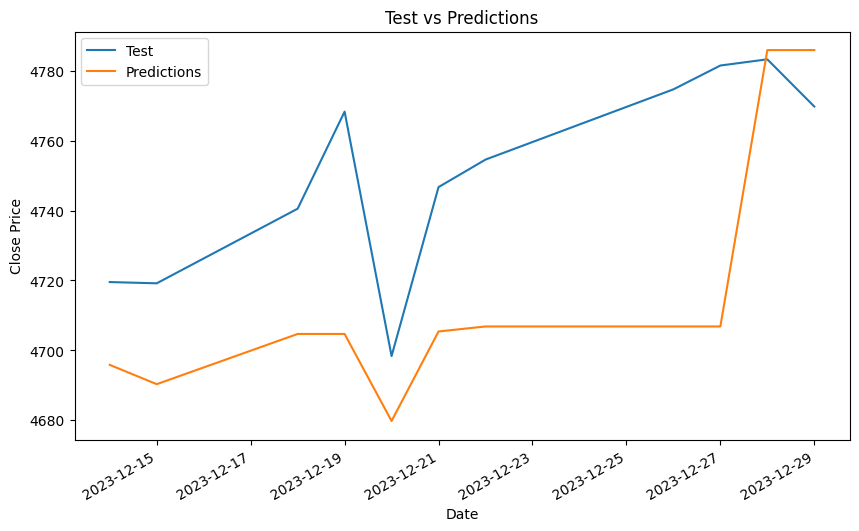

In [18]:
# create a dataframe with the test and predictions data
df1 = pd.DataFrame({'Test': test[target], 'Predictions': predictions})

# plot the test and predictions data as a line graph
df1.plot(kind='line', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Test vs Predictions')
plt.legend()
plt.show()